# Specify experiment and paths

In [1]:
# Specify the experiment for analysis
experiment='xppl2816'
runNumber = 74

# Set the installation and output path
import os
os.environ['INSTALLPATH']='/reg/neh/home4/mrware/PhilTransA-TRXS-Limits'
os.environ['OUTPUTPATH']= '/reg/d/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [2]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/reg/d/psdm/%s/%s/res/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

mrware



In [3]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsTools')
from picklez import *
from mattsTools import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

# Load in the Legendre / Fourier analysis tools
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/trxsToolBox/chiSquare')
from frequencyChiSquare import *
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/trxsToolBox/corrections')
from budarzCorrection import *
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/trxsToolBox/formFactors')
from formFactors import *

/reg/d/psdm/xpp/xppl2816/scratch/Memories/getCSPADcoords remembered!


## Load and plot data

The reconstructor takes a temporal slice from your time-resolved scattering data. Here we plot the full $\Delta$I(Q,T) map. 

Note I suggest restricting your data to regions where you know the signal is not attenuated. For this sample, that is the region above 1.5 $\overset{\circ}{A}^{-1}$

In [4]:
import h5py
hf = h5py.File('phil-trans-data.h5', 'r')
timebins = hf.get('timebins').value - 2.3
mean = hf.get('mean').value
variance = hf.get('variance').value
Q = hf.get('Q').value
legendres = hf.get('legendres').value



(None, None)
(125, 109)
(125,)


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


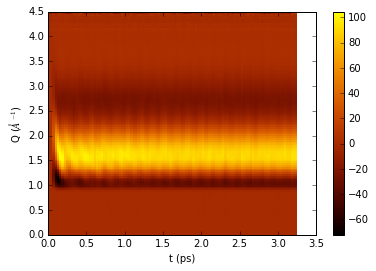

In [5]:
plotme = mean[0,:,:]
t0sub = plotme[:,0]
plotme = plotme - t0sub[:,np.newaxis]

defaultMesh( timebins, Q, 
             plotme, xlabel='t (ps)', ylabel='Q ($\AA^{-1}$)'  )

print(plotme.shape)
print(Q.shape)


## Apply relevant corrections and renormalize

-1
1.1


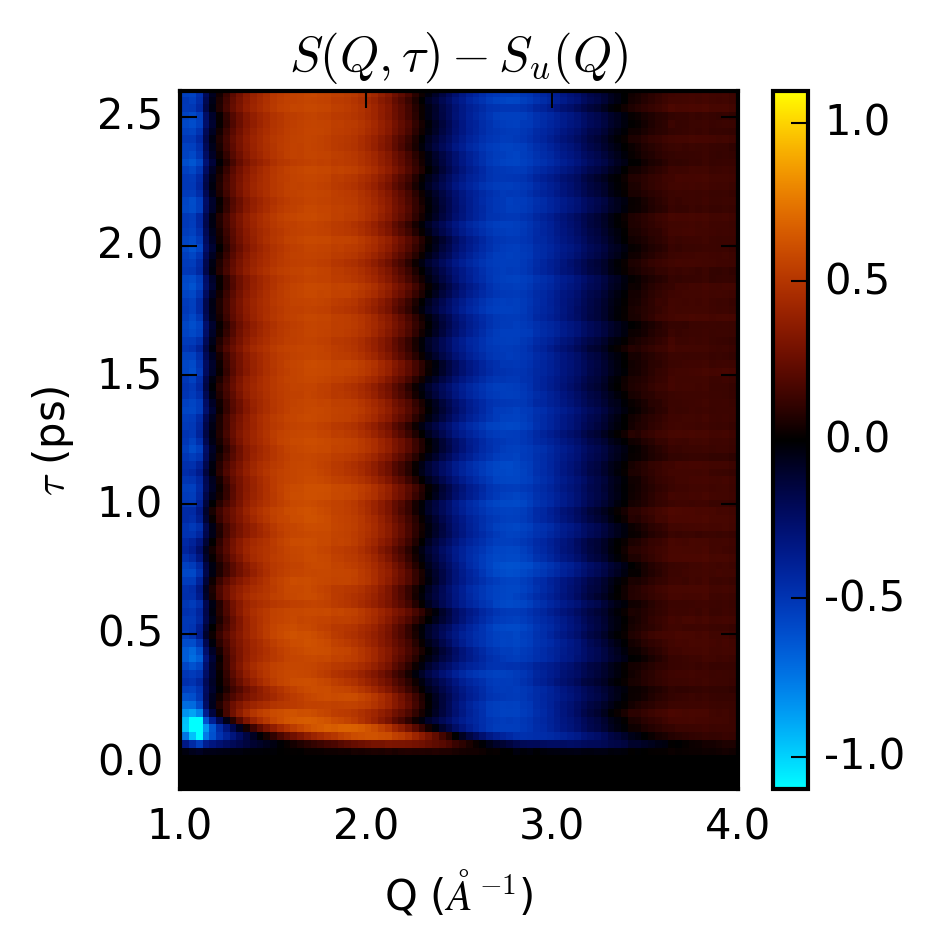

In [53]:
legendreOrder = 0
qIndexes      = (Q > 1.0)&(Q < 4.5)

# Slice out data for analysis
legendreIndex   = (np.array(legendres) == legendreOrder)
Qs              = Q[qIndexes]


muData          = mean[legendreIndex, qIndexes, :]
sigmaData       = variance[legendreIndex, qIndexes, :]

# Generate correction factors
bC = budarzCorrection(np.ones_like(muData[:,0]),Qs,wavelength=1.3776)
fQI = fQ(Qs,'Iodine')

# Apply correction factors across all times
muCData = tileMultiply(bC/fQI**2, muData.T).T
sigmaCData = tileMultiply(bC/fQI**2, sigmaData.T).T

# Normal to maximum signal strength
muNData = muCData / np.abs(muCData).max()
sigmaNData = sigmaCData / np.abs(muCData).max()


# defaultMesh( sampleData['T'], Qs, 
#              muNData, xlabel='t (ps)', ylabel='Q ($\AA^{-1}$)'  )

figOpts = {'xLims':[1.,5], 'yLims':[-.3,2.7], 'zLims':[-1,1], 'yLabel':r'$\tau$', 'yUnits':'ps', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':5, 'nyTicks':7, 'zLabel':r'$S(Q,\tau)-S_u(Q)$', 'divergent':True}
[TT, QQ] = np.meshgrid(timebins  , Qs)
# colorPlot( QQ, TT, mean_subtract(muNData, axis=0), **figOpts )
plotme = muNData
t0sub = muNData[:,0]
plotme = plotme - t0sub[:,np.newaxis]
colorPlot( QQ, TT, plotme/np.abs(plotme).flatten().max()*2 , **figOpts )
fillBackground( figOpts )
plt.ylim([-.1,2.6])
plt.xlim([1,4.])


savefig('TRXS-exp-800nm.eps')

## If even number of data, truncate to make odd

In [54]:
Ts = timebins
if np.mod(Ts.shape[0],2) == 0:
    muNData = muNData[:,:-1]
    sigmaNData = sigmaNData[:,:-1]
    Ts = Ts[:-1]
    

Ts = Ts[10:-6]
muNData = muNData[:,10:-6]
sigmaNData = sigmaNData[:,10:-6]

print muNData.shape
print sigmaNData.shape
print Ts.shape


(96, 93)
(96, 93)
(93,)


## reconstructor: unbounded Chi-Square

For an unbounded Chi-Square of an isotropic distribution, follow this example

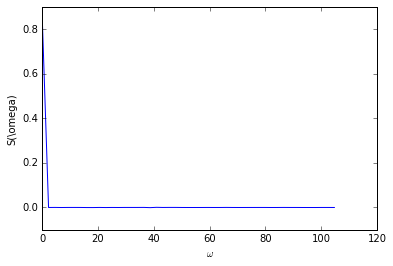

In [55]:
iQ = np.abs(Qs - 2.5).argmin()

myReconstructor = frequencyChiSquare(Ts, 
                       meanSignal = muNData[iQ,:], 
                       stdSignal  = sigmaNData[iQ,:])

myReconstructor.reconstruct()

plt.plot(myReconstructor.Ws,myReconstructor.solution['mu'])
plt.xlabel('$\omega$')
plt.ylabel(r'S(\omega)')


In [56]:
iW = myReconstructor.solution['mu'].argmax()
print myReconstructor.Ws[iW]
print myReconstructor.Ws[iW-1]
print myReconstructor.Ws[iW+1]
print 2*np.pi/myReconstructor.Ws[iW]
print 2*np.pi/myReconstructor.Ws[iW-1]
print 2*np.pi/myReconstructor.Ws[iW+1]

0.0
104.71975512
2.27651641564
inf
0.06
2.76


/reg/g/psdm/sw/conda/inst/miniconda2-prod-rhel7/envs/ana-1.3.9/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


## Updating the reconstructor object for looping over Q bins

In [57]:
myReconstructor = frequencyChiSquare(Ts, 
                       meanSignal = muNData[iQ,:], 
                       stdSignal  = sigmaNData[iQ,:], trigType='cos')#,
#                     wMax = 80)

# Create an array to store reconstruction
# reconstruction = np.zeros(( Qs.shape[0],  2*myReconstructor.Ws.shape[0] ))
# reconstructionE = np.zeros(( Qs.shape[0],  2*myReconstructor.Ws.shape[0] ))
reconstruction = np.zeros(( Qs.shape[0],  myReconstructor.Ws.shape[0] ))
reconstructionE = np.zeros(( Qs.shape[0],  myReconstructor.Ws.shape[0] ))

# Now iterate over your timebins
for iQ in xrange(Qs.shape[0]):
    
    # Update reconstructor
    myReconstructor.updateInitialConditions(muNData[iQ,:], sigmaNData[iQ,:])
    
    # Run reconstructor
    myReconstructor.reconstruct()
    
    # Save solution
    reconstruction[iQ,:] = myReconstructor.solution['mu']
    reconstructionE[iQ,:] = myReconstructor.solution['sigma']
    



-1
Ignoring undefined input variable ...
['zLabel', 'zLims', 'divergent']
1.1


(1, 4.0)

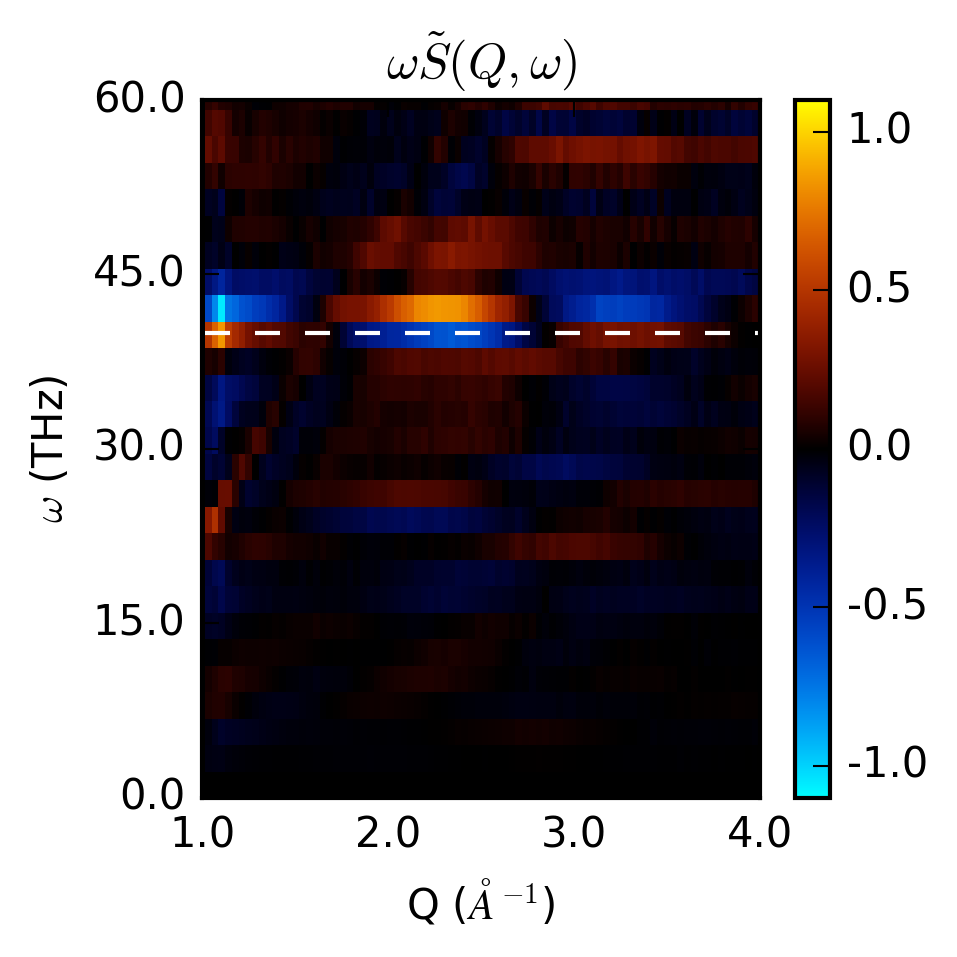

In [58]:
omega = myReconstructor.Ws

[OO, QQ] = np.meshgrid( omega, Qs )
plotMe = reconstruction[:,:omega.size]*OO
# plotMe = reconstruction[:,omega.size:]*OO

# clims = np.array([-1,1])*1.
# figOpts = {'xLims':[1.5,4.], 'yLims':[0,60], 'zLims':clims,  'yLabel':r'$\omega$', 'yUnits':'THz', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
#            'nxTicks':6, 'zLabel':r'$\omega S(\omega)$', 
#               'divergent':True}


clims = np.array([-1,1])
figOpts = {'xLims':[1.,4.], 'yLims':[0,60], 'zLims':clims,  'yLabel':r'$\omega$', 'yUnits':'THz', 'xLabel':'Q', 'xUnits':r'$\AA^{-1}$',
           'nxTicks':4, 'zLabel':r'$\omega \tilde{S}(Q,\omega)$', 
              'divergent':True}

colorPlot( QQ, OO, (plotMe)*20, **figOpts )


linePlot( Qs, 40*np.ones_like(Qs), newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 80*np.ones_like(Qs), newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 27*Qs-5, newFigure=False, plotOptions={'color':'w', 'linestyle':'--'}, **figOpts )
# linePlot( Qs, 16.7*Qs*np.sqrt(2), newFigure=False, plotOptions={'color':'w', 'linestyle':':'}, **figOpts )

# linePlot(Qs, 40.2768288922*np.ones_like(Qs), newFigure=False, **figOpts)

fillBackground( figOpts )

plt.xlim([1,4.])

# savefig('FTIXS-exp-800nm.eps')

## Grab lineout right below 45 THz

17
38.700779066
Ignoring undefined input variable ...
[]
Ignoring undefined input variable ...
[]
Ignoring undefined input variable ...
[]


(1, 4)

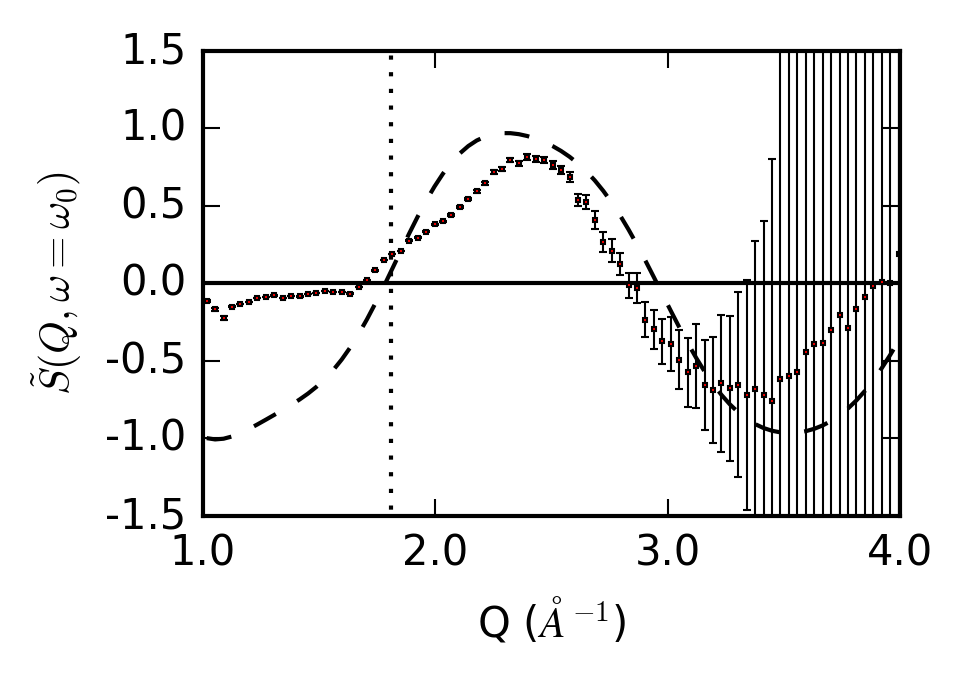

In [64]:
ind = np.abs(plotMe[30,(omega<60)]).argmax()  -1

# ind = 45

print ind 
print omega[ind]

figOpts = {'xLims':[1.,4.], 'yLims':[-1.5,1.5], 'nxTicks':4, 'nyTicks':7,
           'yLabel':r'$\tilde{S}(Q,\omega=\omega_0)$', 'xLabel':'Q', 'xUnits':'$\AA^{-1}$'}

ys = plotMe[:,ind] * Qs**2
# linePlot(Qs, ys/ys.max()/.5, plotOpts={'linestyle':':'}, **figOpts)

q = Qs
r0 = 2.666
# r0 = 3.72

sTheory = np.cos( q*r0 ) - np.sinc(q*r0)

# sTheory = np.sin( q*r0 ) 

# linePlot(Qs, sTheory, **figOpts)

# plt.plot(Qs,sTheory)
# plt.errorbar(Qs, ys/ys[:50].max()*1.2, yerr=reconstructionE[:,ind]*Qs**2/ys[:50].max()*1.2,barsabove=True, fmt='o')


linePlot(Qs, np.zeros_like(sTheory), newFigure=True, plotOptions={'color':'k'}, **figOpts)

line,caps,bars=plt.errorbar(
    Qs,     # X
    -ys*4.5,    # Y
    yerr=reconstructionE[:,ind]*4.5*Qs**2*10000,        # Y-errors
    fmt="rs",    # format line like for plot()
    linewidth=3,   # width of plot line
    elinewidth=0.5,# width of error bar line
    ecolor='k',    # color of error bar
    capsize=1,     # cap length for error bar
    capthick=0.5,   # cap thickness for error bar
    ms=1
    )

# sD = load_obj('twoomega')

# linePlot( sD['Q']*1/.53, (sD['S']-1)/np.max(sD['S']-1), newFigure = False, **figOpts )

# plt.scatter(Qs, ys/ys[:50].max()*1.2, s=.8, color='red', zorder=100)
linePlot(Qs, sTheory, newFigure=False, **figOpts)

# linePlot( [4.43,4.43] , [-2,2], newFigure=False, plotOptions={'color':'k'},**figOpts )

linePlot( [1.81,1.81] , [-2,2], newFigure=False, plotOptions={'color':'k'},**figOpts )

plt.xlim([1,4])

# savefig('classical-exp-comp-800nm.eps')
